In [98]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import os
import scipy.constants as const
from numpy import linalg as LA

#import ParticlePlottingFunctions
import ParticlePlottingFunctions as ppf
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# file1 = "100UCN_fill_SCM_track.root"
file1 = "400UCN_Fill_trackAndSpinSCM.root"

#get our two different data folders already for ease
Nend = up.open(file1+":neutronend")
Nsnapshot = up.open(file1+":neutronsnapshot")
Ntrack = up.open(file1+":neutrontrack")
# Nspin = up.open(file1+":spinlog")

In [29]:
'''
jobnumber: job number of the PENTrack run (passed per command line parameter)
particle: number of particle being simulated
t: time [s]
x, y, z: location of the neutron at time t [m]
Sx, Sy, Sz: components of the spin vector [dimensionless]
Wx, Wy, Wz: components of precession-axis vector [1/s]
Bx, By, Bz: field experienced by the neutron at time t [Tesla]
'''

# particleSpin_all = Nspin.arrays(['particle', 't', 'x', 'y', 'z', 'Sx', 'Sy', 'Sz', 'Bx', 
#                                   'By', 'Bz'], library="np")

particleEnd_all = Nend.arrays(['particle', 'tstart', 'xstart', 'ystart', 'zstart', 'polstart', 'Hstart', 
                               'Estart', 'solidstart', 'tend', 'xend', 'yend', 'zend', 'polend', 'Hend',
                               'Eend', 'Bend', 'solidend', 'stopID', 'Nspinflip', 'Sxstart', 'Systart',
                               'Szstart', 'Sxend', 'Syend', 'Szend'], library="np")

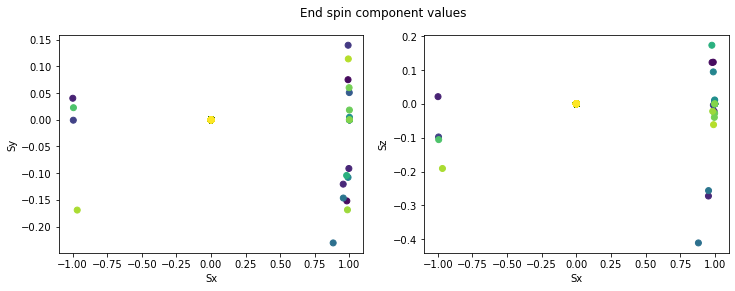

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
plt.suptitle("End spin component values")

axs[0].scatter(particleEnd_all['Sxend'], particleEnd_all['Syend'], marker="o", c=particleEnd_all['particle'])
axs[0].set_xlabel('Sx')
axs[0].set_ylabel('Sy')
# axs[0].set_xlim(0, 1.5)

axs[1].scatter(particleEnd_all['Sxend'], particleEnd_all['Szend'], marker="o", c=particleEnd_all['particle'])
axs[1].set_xlabel('Sx')
axs[1].set_ylabel('Sz')
# axs[1].set_xlim(0, 1.5)
plt.show()

In [78]:
# print(Ntrack.keys())

particleTrack_all = Ntrack.arrays(['particle', 'polarisation', 't', 'x', 'y', 'z', 'vx', 'vy', 'vz', 
                    'H', 'E', 'Bx', 'dBxdx', 'dBxdy', 'dBxdz', 'By', 'dBydx', 'dBydy', 
                                   'dBydz', 'Bz', 'dBzdx', 'dBzdy', 'dBzdz'], library="np")

particleTrack_one = Ntrack.arrays(['particle', 'polarisation', 't', 'x', 'y', 'z', 'vx', 'vy', 'vz', 
                    'H', 'E', 'Bx', 'dBxdx', 'dBxdy', 'dBxdz', 'By', 'dBydx', 'dBydy', 
                                   'dBydz', 'Bz', 'dBzdx', 'dBzdy', 'dBzdz'], "(particle==397) & (x > 0)", library="np")

In [84]:
nonZeroB = np.where(particleTrack_all['Bx'] != 0)

#particle numbers with non-zero Bx entries
print(set(particleTrack_all['particle'][nonZeroB]))

{1.0, 2.0, 3.0, 4.0, 7.0, 11.0, 12.0, 14.0, 16.0, 20.0, 23.0, 24.0, 25.0, 27.0, 28.0, 29.0, 32.0, 35.0, 36.0, 39.0, 43.0, 44.0, 45.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 55.0, 56.0, 62.0, 67.0, 69.0, 72.0, 75.0, 76.0, 77.0, 80.0, 85.0, 87.0, 90.0, 92.0, 102.0, 105.0, 108.0, 112.0, 115.0, 116.0, 119.0, 123.0, 128.0, 129.0, 130.0, 131.0, 132.0, 135.0, 140.0, 141.0, 144.0, 146.0, 148.0, 149.0, 150.0, 153.0, 155.0, 156.0, 158.0, 159.0, 160.0, 164.0, 167.0, 170.0, 172.0, 175.0, 177.0, 179.0, 180.0, 182.0, 183.0, 189.0, 190.0, 192.0, 195.0, 196.0, 197.0, 200.0, 201.0, 204.0, 205.0, 206.0, 208.0, 209.0, 211.0, 212.0, 213.0, 214.0, 215.0, 216.0, 218.0, 219.0, 220.0, 230.0, 231.0, 232.0, 233.0, 245.0, 250.0, 251.0, 252.0, 254.0, 256.0, 258.0, 259.0, 260.0, 263.0, 264.0, 269.0, 272.0, 275.0, 276.0, 277.0, 283.0, 285.0, 288.0, 289.0, 290.0, 293.0, 294.0, 296.0, 297.0, 300.0, 302.0, 305.0, 306.0, 309.0, 310.0, 311.0, 312.0, 314.0, 315.0, 316.0, 318.0, 321.0, 322.0, 323.0, 324.0, 326.0, 328.0

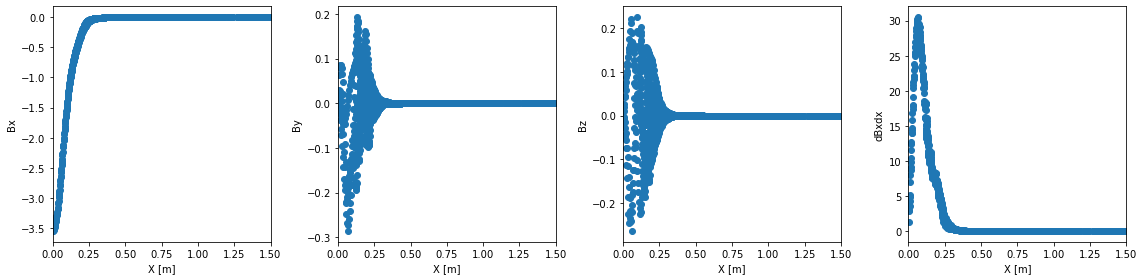

In [80]:
## Look at B vs positions

fig, axs = plt.subplots(1, 4, figsize=(16,4))

axs[0].plot(particleTrack_one['x'], particleTrack_one['Bx'], ls="", marker="o")
axs[0].set_ylabel('Bx')
axs[0].set_xlabel('X [m]')
axs[0].set_xlim(0, 1.5)

axs[1].plot(particleTrack_one['x'], particleTrack_one['By'], ls="", marker="o")
axs[1].set_ylabel('By')
axs[1].set_xlabel('X [m]')
axs[1].set_xlim(0, 1.5)

axs[2].plot(particleTrack_one['x'], particleTrack_one['Bz'], ls="", marker="o")
axs[2].set_ylabel('Bz')
axs[2].set_xlabel('X [m]')
axs[2].set_xlim(0, 1.5)

axs[3].plot(particleTrack_one['x'], particleTrack_one['dBxdx'], ls="", marker="o")
axs[3].set_ylabel('dBxdx')
axs[3].set_xlabel('X [m]')
axs[3].set_xlim(0, 1.5)

plt.tight_layout()

plt.show()

In [188]:
gamma_n = const.physical_constants['neutron gyromag. ratio'][0] #s^-1 T^-1, negative

'''
I trust this one a lot more
equation 3.14 from https://tel.archives-ouvertes.fr/tel-00726870 by E. Pierre

but this one really returns a k value for the range between two points, not actually
a point itself.

Problems: 
- not totally sure what the just B should be
- how small a step this is valid for?
'''
def K_equ3_14(v_vec, B_1, B_2, r_1, r_2):
    #what to use for this value of the field?
    B = LA.norm(B_1)
    v_n = LA.norm(v_vec)
    B_1_norm = LA.norm(B_1)
    B_2_norm = LA.norm(B_2)
    
    #the angle that the field changes by
    if B_1_norm*B_2_norm == 0: 
        #just return the nonsense value of -1 if B is 0 here?
#         print(B_1_norm, B_2_norm)
        k = -np.inf
    else:
        theta = np.arccos(B_1@B_2/(B_1_norm*B_2_norm))
    
        #the distance for that change
        delta_distance = LA.norm(r_2 - r_1)

        #k calculation
        k = gamma_n*B*delta_distance / (v_n * theta)

    return k

def getKValue(particleTrack_one):
    
    #put all the particle's values into a better form for us 
    v_n_vec = []
    B_1_vec = []
    B_2_vec = []
    point_1_vec = []
    point_2_vec = []
    
    #we need the values for two points at a time
    for i, t in enumerate(particleTrack_one['t'][:-1]):

        v_n_vec.append(np.array([particleTrack_one['vx'][i], particleTrack_one['vy'][i], particleTrack_one['vz'][i]]))

        B_1_vec.append(np.array([particleTrack_one['Bx'][i], particleTrack_one['By'][i], particleTrack_one['Bz'][i]]))
        B_2_vec.append(np.array([particleTrack_one['Bx'][i+1], particleTrack_one['By'][i+1], particleTrack_one['Bz'][i+1]]))

        point_1_vec.append(np.array([particleTrack_one['x'][i], particleTrack_one['y'][i], particleTrack_one['z'][i]]))
        point_2_vec.append(np.array([particleTrack_one['x'][i+1], particleTrack_one['y'][i+1], particleTrack_one['z'][i+1]]))

    #change them fully into arrays to use
    v_n_vec = np.array(v_n_vec)
    B_1_vec = np.array(B_1_vec)
    B_2_vec = np.array(B_2_vec)
    point_1_vec = np.array(point_1_vec)
    point_2_vec = np.array(point_2_vec)

    #actually get the adiabatic parameter for each position range 
    k_314 = [K_equ3_14(v_n_vec[i], B_1_vec[i], B_2_vec[i], point_1_vec[i], point_2_vec[i]) for i in range(len(v_n_vec))]

    return v_n_vec, B_1_vec, B_2_vec, point_1_vec, point_2_vec, k_314

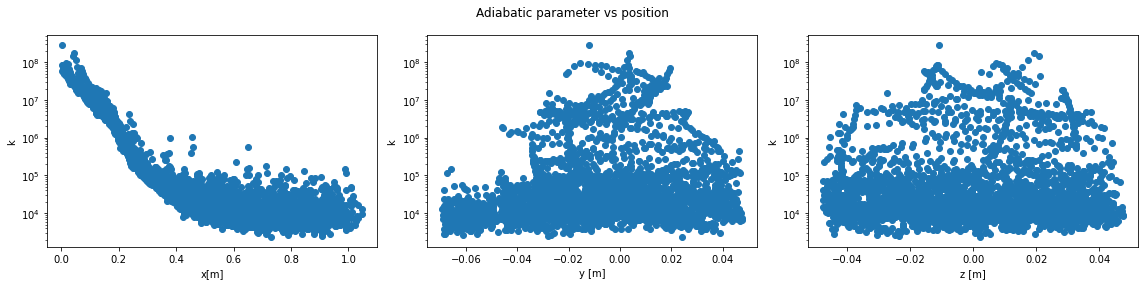

In [189]:
# K_equ3_14(v_n, B_1, B_2, r_1, r_2)

v_n_vec, B_1_vec, B_2_vec, point_1_vec, point_2_vec, k_314 = getKValue(particleTrack_one)

# print(k)
fig, axs = plt.subplots(1, 3, figsize=(16,4))

axs[0].semilogy(point_1_vec[:,0], k_314, ls="", marker="o")
axs[0].set_ylabel('k')
axs[0].set_xlabel('x[m]')

axs[1].semilogy(point_1_vec[:,1], k_314, ls="", marker="o")
axs[1].set_ylabel('k')
axs[1].set_xlabel('y [m]')

axs[2].semilogy(point_1_vec[:,2], k_314, ls="", marker="o")
axs[2].set_ylabel('k')
axs[2].set_xlabel('z [m]')

plt.suptitle("Adiabatic parameter vs position")
plt.tight_layout()
plt.show()

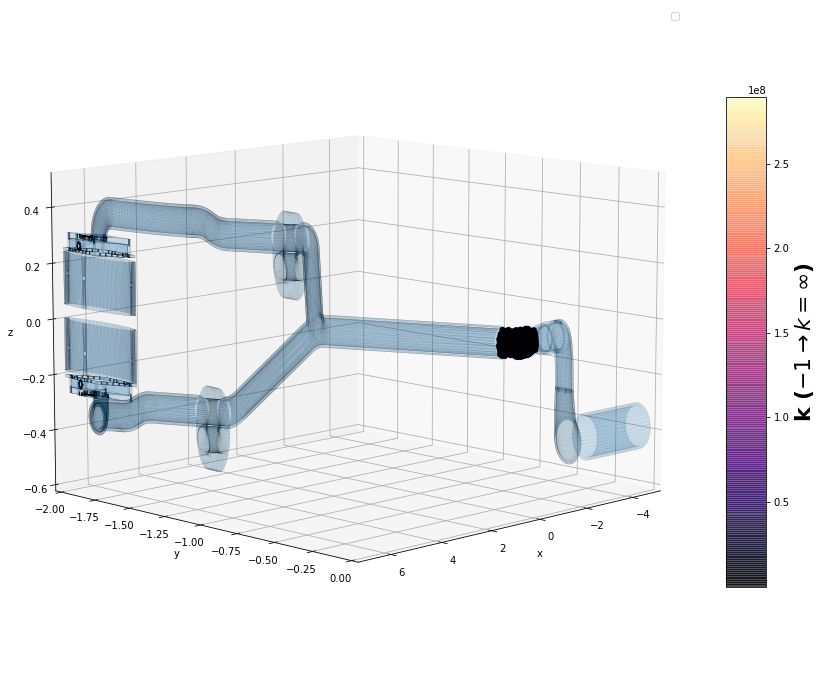

In [186]:
%matplotlib inline 
#lets you move the graph around within jupyter lab
# %matplotlib widget
   
figVals = ppf.plot3D_varColor(point_1_vec[:,0], point_1_vec[:,1], point_1_vec[:,2], k_314, label="All", startPlot=True, ls="", 
                              endPlot=False, size=(15,15))
fig, axis, p = figVals

axis.view_init(elev=10., azim=45)
# axis.view_init(elev=0., azim=90)

#loads all the file I have in this folder as STLs
STLpath = 'STLsToGraph'
stl_array = os.listdir(STLpath)

for STLfile in stl_array:
    ppf.graphSTL(STLpath+'/'+STLfile, axis)
    
#removes repeated legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axis.legend(by_label.values(), by_label.keys())

cb = fig.colorbar(p, ax=axis, shrink=0.6, aspect=20*0.6)
cb.set_label(label="k ($-1 \\rightarrow k=\\infty$)", size=22, weight='bold')
# cb.ax.tick_params(labelsize=20)
# plt.tight_layout()
plt.show()

In [ ]:
## The old 

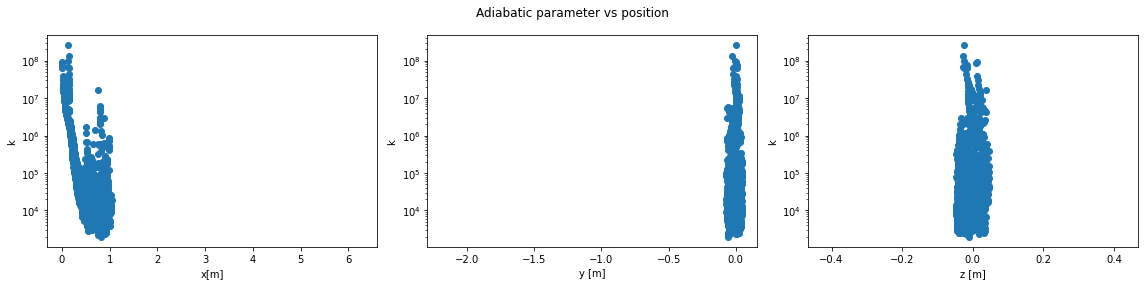

In [168]:
'''
The adiabatic parameter - but not really cause dbdx is just wrong
'''
def K_equ3_12(B, dbdx, v_n):
    if dbdx == 0:
        k = -1
    else:
        k = gamma_n*B**2 / (v_n*dbdx)
    return k

x = particleTrack_one['x'].astype(float)
y = particleTrack_one['y'].astype(float)
z = particleTrack_one['z'].astype(float)
times = particleTrack_one['t'].astype(float)

#magnitude of total B field
B = np.sqrt(particleTrack_one['Bx']**2 + particleTrack_one['By']**2 + particleTrack_one['Bz']**2)

#adiabatic parameter for each position 
k = [K_equ3_12(B[i], particleTrack_one['dBxdx'][i], 
            particleTrack_one['vx'][i]) for i in range(len(particleTrack_one['Bx']))]
# print(k)
fig, axs = plt.subplots(1, 3, figsize=(16,4))

axs[0].semilogy(x, k, ls="", marker="o")
axs[0].set_ylabel('k')
axs[0].set_xlabel('x[m]')

axs[1].semilogy(y, k, ls="", marker="o")
axs[1].set_ylabel('k')
axs[1].set_xlabel('y [m]')

axs[2].semilogy(z, k, ls="", marker="o")
axs[2].set_ylabel('k')
axs[2].set_xlabel('z [m]')

plt.suptitle("Adiabatic parameter vs position")
plt.tight_layout()
plt.show()

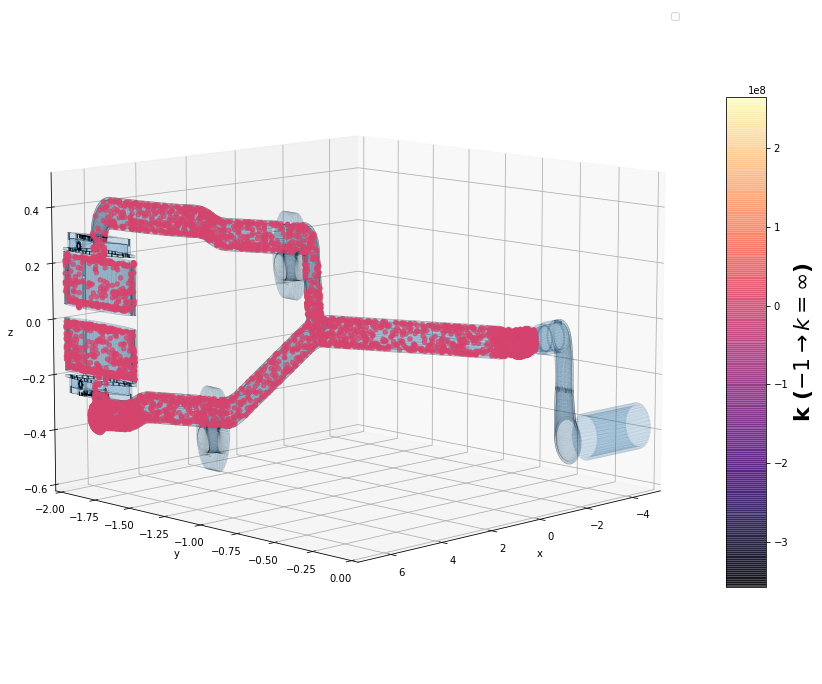

In [169]:
%matplotlib inline 
#lets you move the graph around within jupyter lab
# %matplotlib widget
   
figVals = ppf.plot3D_varColor(x, y, z, k, times, label="All", startPlot=True, ls="", 
                              endPlot=False, size=(15,15))
fig, axis, p = figVals

axis.view_init(elev=10., azim=45)
# axis.view_init(elev=0., azim=90)

#loads all the file I have in this folder as STLs
STLpath = 'STLsToGraph'
stl_array = os.listdir(STLpath)

for STLfile in stl_array:
    ppf.graphSTL(STLpath+'/'+STLfile, axis)
    
#removes repeated legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axis.legend(by_label.values(), by_label.keys())

cb = fig.colorbar(p, ax=axis, shrink=0.6, aspect=20*0.6)
cb.set_label(label="k ($-1 \\rightarrow k=\\infty$)", size=22, weight='bold')
# cb.ax.tick_params(labelsize=20)
# plt.tight_layout()
plt.show()